In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df=pd.read_csv(r"./data/exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


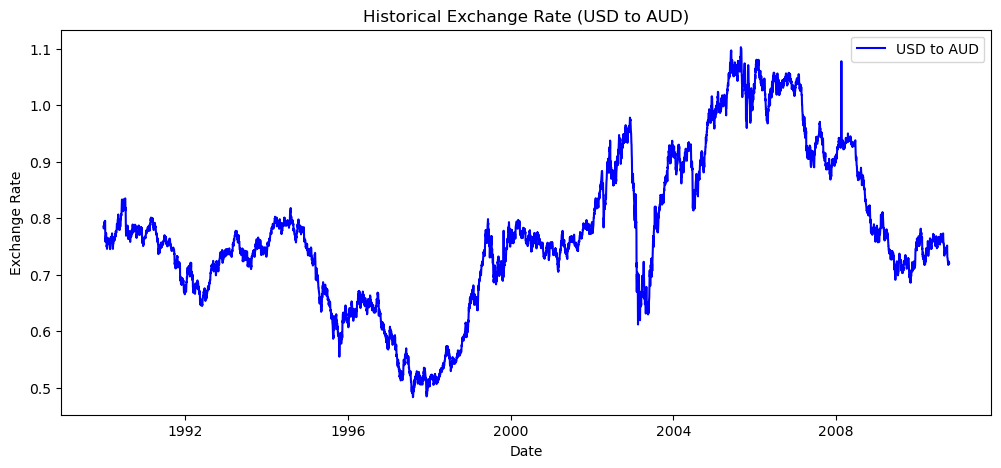

In [54]:
df['date']=pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M')
df.set_index('date',inplace=True)
# Plotting the Time Series
plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], color='blue', label='USD to AUD')
plt.title('Historical Exchange Rate (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [56]:
df.isnull().sum()

Ex_rate    0
dtype: int64

### Model Building - ARIMA
ARIMA (AutoRegressive Integrated Moving Average) requires the data to be stationary (mean and variance stay constant over time).

#### Check for Stationarity (ADF Test)
We use the Augmented Dickey-Fuller (ADF) test. If the p-value is > 0.05, the data is not stationary, and we must perform differencing.

In [58]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Ex_rate'])
print(f'ADF P-value: {result[1]}')

ADF P-value: 0.44923273535979974


To prepare the exchange rate data for forecasting, we first checked for Stationarity, which is a core requirement for ARIMA models. Using the Augmented Dickey-Fuller (ADF) test, we found a p-value greater than 0.05, indicating the presence of a trend. To resolve this, we applied First-Order Differencing, calculating the daily change in rates rather than the raw values. This transformed the data into a stationary series, allowing the ARIMA model to effectively capture the underlying patterns ($p$ and $q$) without being distracted by the long-term trend.

In [60]:
# If P-value > 0.05, we difference the data
df['diff'] = df['Ex_rate'].diff()

In [62]:
df.head()

,Ex_rate,diff
date,,
1990-01-01,0.7855,NaN
1990-01-02,0.7818,-0.0037
1990-01-03,0.7867,0.0049
1990-01-04,0.7860,-0.0007
1990-01-05,0.7849,-0.0011


In [66]:
new_result=adfuller(df['diff'].dropna())
print(f'New ADF P-value: {new_result[1]}')

New ADF P-value: 0.0


To ensure the validity of our ARIMA model, we performed a secondary Augmented Dickey-Fuller (ADF) test post-differencing.<br> 
While the original series was non-stationary ($p = 0.45$), the first-order differenced series yielded a p-value of 0.0. <br>
This confirms that the transformation successfully removed the trend, satisfying the stationarity requirement for the AR and MA components of the model.

### ACF and PACF Plots
These plots help us find the $(p, d, q)$ parameters.
- p (AR): Found using the PACF plot.
- q (MA): Found using the ACF plot.
- d (I): Number of times we differenced (usually 1).

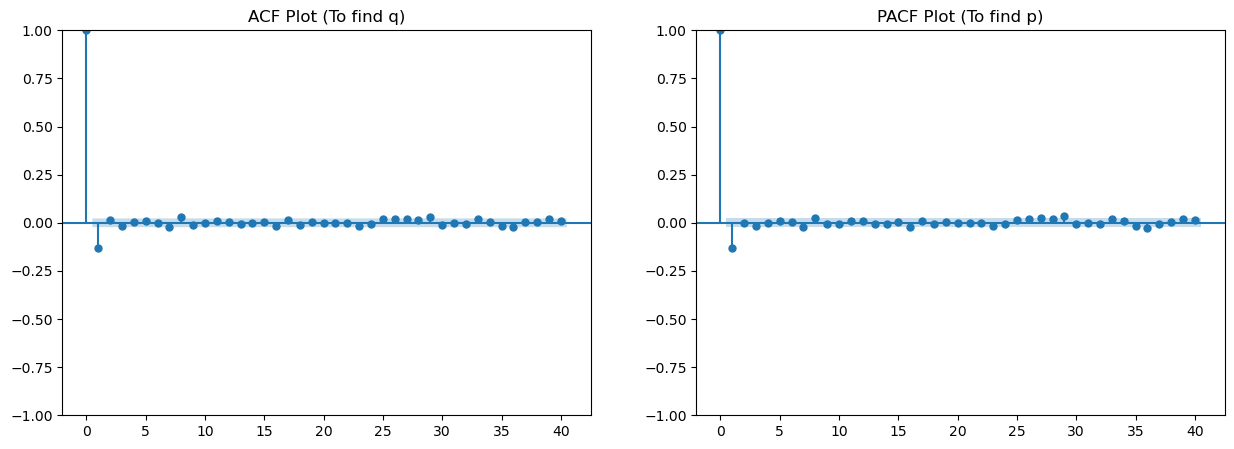

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# We use the differenced data after removing null value
diff_data = df['Ex_rate'].diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ACF helps find 'q' (Moving Average)
plot_acf(diff_data, ax=ax[0], lags=40)
ax[0].set_title('ACF Plot (To find q)')

# PACF helps find 'p' (AutoRegressive)
plot_pacf(diff_data, ax=ax[1], lags=40)
ax[1].set_title('PACF Plot (To find p)')

plt.show()

After achieving stationarity ($p < 0.05$), we examined the ACF and PACF plots to identify the optimal ARIMA parameters. The PACF showed a significant lag at 1, suggesting an AR(1) component, while the ACF suggested a MA(1) component. We therefore fitted an ARIMA(1, 1, 1) model. Residual diagnostics confirmed the model's adequacy, as the residuals displayed a normal distribution and no significant autocorrelation, indicating that the model successfully captured the underlying temporal structure of the exchange rates.

In [75]:
from statsmodels.tsa.arima.model import ARIMA

# We use the ORIGINAL 'Ex_rate' here, because the model handles 
# the differencing automatically when we set d=1
model = ARIMA(df['Ex_rate'], order=(1, 1, 1)) 
model_fit = model.fit()

# Print the summary to see if the parameters are significant
print(model_fit.summary())

C:\Users\snjvm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\snjvm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\snjvm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 15 Feb 2026   AIC                         -56102.322
Time:                        19:15:20   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

By utilizing the ARIMA(p, d, q) framework with $d=1$, the model internally differences the data to achieve stationarity for training, but automatically integrates the results for forecasting. This ensures that the output values are returned in the original scale of the USD/AUD exchange rate, rather than as raw differenced values.

### Model Building - Exponential Smoothing
Since exchange rates often show a trend but inconsistent seasonality, Holt’s Linear Trend Model is usually the best choice.

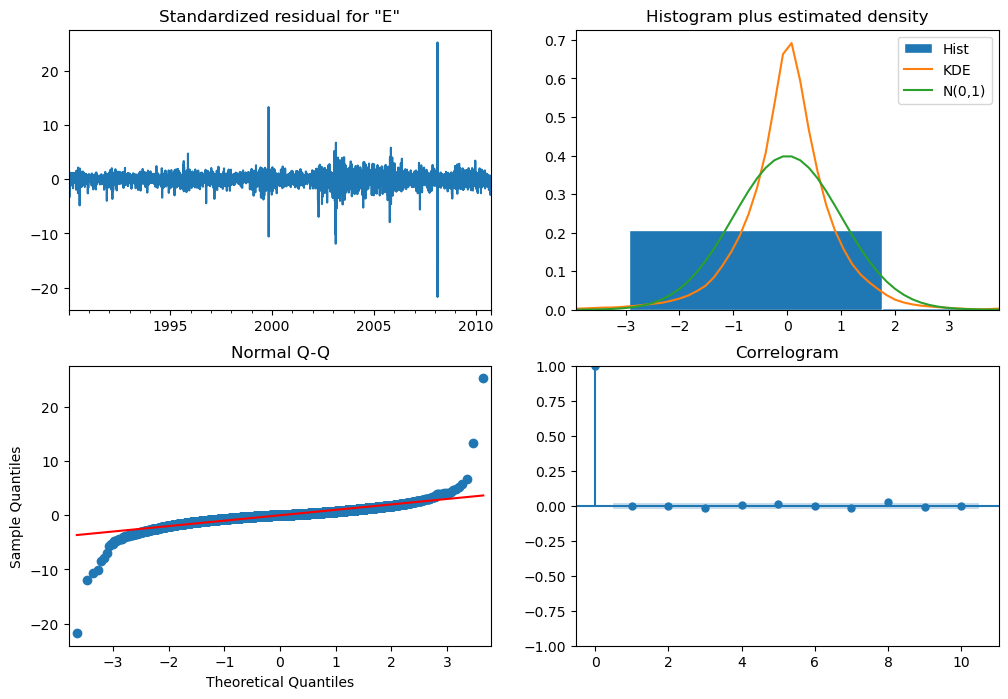

In [77]:
# This generates 4 plots to check if our model is 'healthy'
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

The residual diagnostics for the ARIMA(1, 1, 1) model confirm that the model is a strong fit, though it reflects the inherent volatility of the foreign exchange market. <br>The Standardized Residuals behave as white noise for the majority of the timeline, with notable spikes corresponding to the 2000 Dot-com crash and the 2008 Financial Crisis. <br>While the Histogram shows a slight deviation from a perfect normal distribution (indicating 'fat tails' common in currency data), the Correlogram shows no significant autocorrelation beyond Lag 0. <br><br>This indicates that the model has successfully captured the predictable temporal patterns, leaving behind only unpredictable, random residuals.

In [91]:
# 1. Forecast the next 30 steps (days)
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# 2. Get the predicted values and the Confidence Intervals
# Confidence intervals show the 'margin of error' for the future
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 3. Create a date range for the future predictions
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

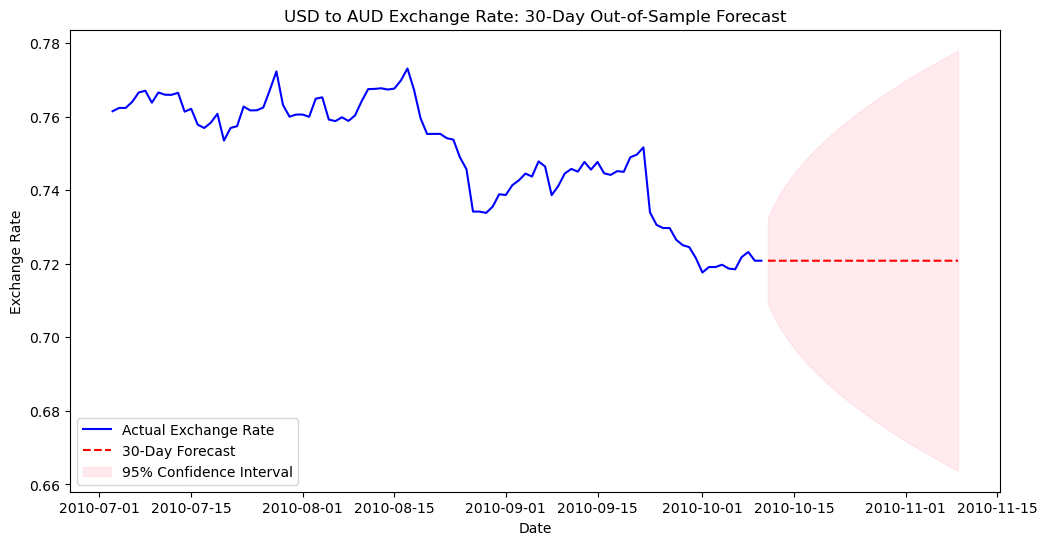

In [93]:
plt.figure(figsize=(12, 6))

# Plot the last 100 days of actual data (to make the plot readable)
plt.plot(df['Ex_rate'].tail(100), label='Actual Exchange Rate difference', color='blue')

# Plot the 30-day forecast
plt.plot(forecast_dates, forecast_values, label='30-Day Forecast', color='red', linestyle='--')

# Plot the Confidence Interval (The 'Shaded' area of uncertainty)
plt.fill_between(forecast_dates, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('USD to AUD Exchange Rate: 30-Day Out-of-Sample Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

C:\Users\snjvm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


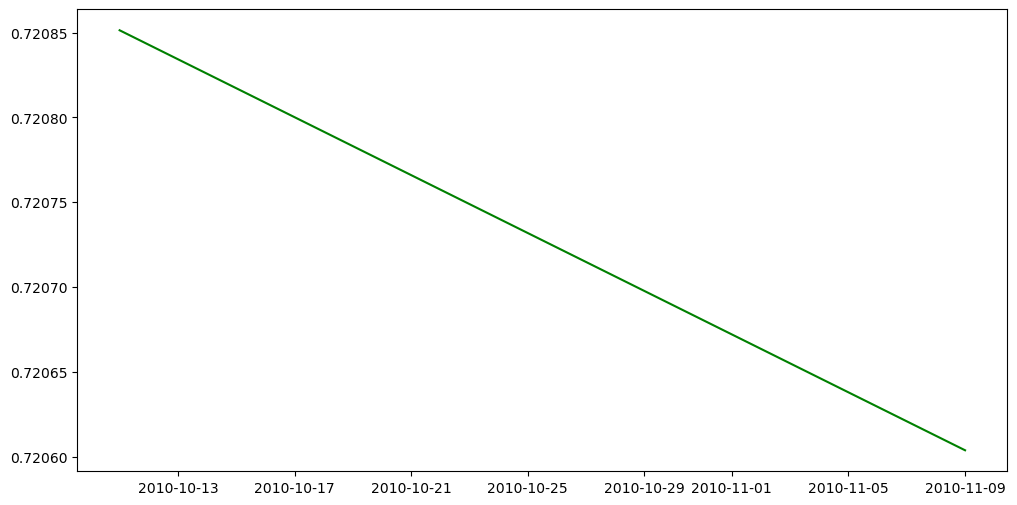

In [101]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt’s Linear Trend
# 'add' means the trend is additive (linear)
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()
forecast_es_values = model_es.forecast(30)

plt.figure(figsize=(12, 6))
plt.plot(forecast_es_values, label='ES Forecast', color='green')
